In [1]:
import os

os.chdir(os.path.expanduser("~/l3_project"))
# for when on NCC to be able to import local packages

In [4]:
import time
import platform

import numpy as np
import einops.einops as einops
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torchvision.transforms.v2 as transforms
import wandb
import safetensors.torch as st

import dataset_processing.core
import dataset_processing.eurosat
import dataset_processing.ucmerced

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


## EuroSAT images

In [38]:
testing_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),
    transforms.ToDtype(torch.float32, scale=True),
])

eurosat_test_ds = dataset_processing.eurosat.get_dataset("test",
                                                         bands=( "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B10", "B11", "B12"),
                                                         transforms=testing_transforms,
                                                         download=False)

In [43]:
num_examples = 10
num_classes = len(eurosat_test_ds.classes)

torch.random.manual_seed(42)
all_examples = iter(torch.utils.data.DataLoader(eurosat_test_ds, shuffle=True))
sample_images = torch.zeros(num_classes, num_examples, *eurosat_test_ds[0]["image"].shape)
classes_added = np.array([0 for _ in range(num_classes)])
while not np.all(classes_added == num_examples):
    item = next(all_examples)
    im, label = item["image"], item["label"]
    label = int(label)
    if classes_added[label] < num_examples:
        sample_images[label, classes_added[label]] = im
        classes_added[label] += 1
sample_images = sample_images.cpu()
sample_images.size()

torch.Size([10, 10, 13, 224, 224])

torch.Size([10, 10, 13, 224, 224])

AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


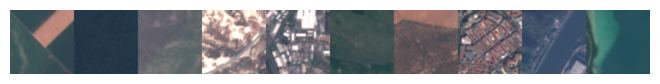

In [57]:
image_row = einops.rearrange((sample_images[:, 2, [3,2,1]]/3000).clip(0, 1), 'e c h w -> h (e w) c')
# plt.imsave("output/eurosat_image_row_2.png", image_row.numpy())
plt.imshow(image_row)
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)
print(", ".join(eurosat_test_ds.classes))

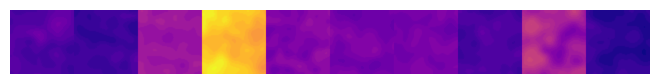

In [103]:
one_row = einops.rearrange((sample_images[:, 2, 9]/3000).clip(0, 1), 'e h w -> h (e w)')
plt.imsave("output/eurosat_image_row_2_B10.png", one_row.numpy())
plt.imshow(one_row, cmap="plasma")
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

In [104]:
# https://sentiwiki.copernicus.eu/web/s2-applications
ndvi = (sample_images[:, :, 7] - sample_images[:, :, 3])/(sample_images[:, :, 7] + sample_images[:, :, 3])  # vegetation index
ndwi = (sample_images[:, :, 2] - sample_images[:, :, 7])/(sample_images[:, :, 2] + sample_images[:, :, 7])  # water index
ndvi.size()

torch.Size([10, 5, 224, 224])

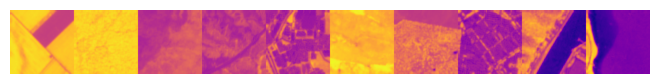

In [105]:
image_row = einops.rearrange(ndvi[:, 2], 'e h w -> h (e w)')
plt.imsave("output/eurosat_image_row_2_ndvi.png", image_row.numpy())
plt.imshow(image_row, cmap="plasma")
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

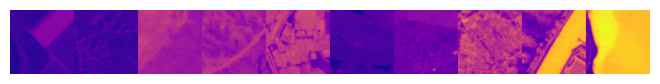

In [106]:
image_row = einops.rearrange(ndwi[:, 2], 'e h w -> h (e w)')
plt.imsave("output/eurosat_image_row_2_ndwi.png", image_row.numpy())
plt.imshow(image_row, cmap="plasma")
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

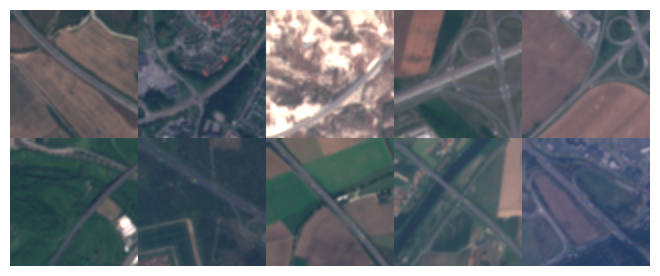

In [47]:
image_row = einops.rearrange((sample_images[3, :, [3,2,1]]/3000).clip(0, 1), '(e1 e2) c h w -> (e1 h) (e2 w) c', e1=2)
# plt.imsave("output/eurosat_rivers.png", image_row.numpy())
plt.imshow(image_row)
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

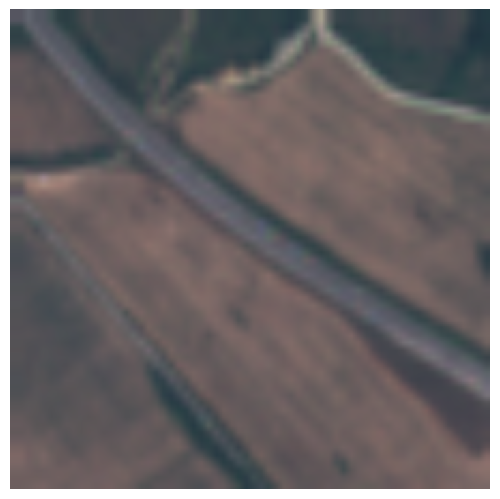

In [52]:
plt.imshow((sample_images[3, 0, [3,2,1]]/3000).clip(0, 1).numpy().transpose(1, 2, 0))
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

## UC Merced images

In [53]:
testing_transforms = transforms.Compose([
    transforms.Resize((256, 256), antialias=False),

    transforms.ToDtype(torch.float32, scale=True),
])

ucmerced_test_dataset = dataset_processing.ucmerced.get_dataset("test", testing_transforms, download=False)

In [54]:
num_examples = 5
num_classes = len(ucmerced_test_dataset.classes)

torch.random.manual_seed(42)
all_examples = iter(torch.utils.data.DataLoader(ucmerced_test_dataset, shuffle=True))
sample_images = torch.zeros(num_classes, num_examples, *ucmerced_test_dataset[0]["image"].shape)
classes_added = np.array([0 for _ in range(num_classes)])
while not np.all(classes_added == num_examples):
    item = next(all_examples)
    im, label = item["image"], item["label"]
    label = int(label)
    if classes_added[label] < num_examples:
        sample_images[label, classes_added[label]] = im
        classes_added[label] += 1
sample_images = sample_images.cpu()
print(sample_images.size())
print(", ".join(ucmerced_test_dataset.classes))

torch.Size([21, 5, 3, 256, 256])
agricultural, airplane, baseballdiamond, beach, buildings, chaparral, denseresidential, forest, freeway, golfcourse, harbor, intersection, mediumresidential, mobilehomepark, overpass, parkinglot, river, runway, sparseresidential, storagetanks, tenniscourt
torch.Size([21, 5, 3, 256, 256])
agricultural, airplane, baseballdiamond, beach, buildings, chaparral, denseresidential, forest, freeway, golfcourse, harbor, intersection, mediumresidential, mobilehomepark, overpass, parkinglot, river, runway, sparseresidential, storagetanks, tenniscourt


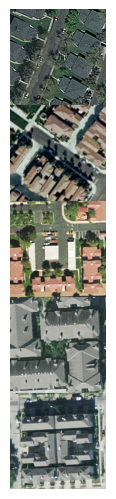

In [22]:
images = einops.rearrange((sample_images[6, :]).clip(0, 1), 'e c h w -> (e h) w c')
plt.imsave("output/ucmerced_denseresidentials.png", images.numpy())
plt.imshow(images)
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

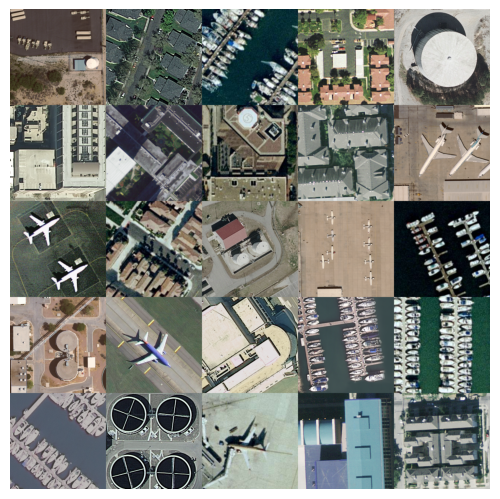

In [29]:
images = einops.rearrange((sample_images[[1, 4, 6, 10, -2], :]).clip(0, 1).flatten(0, 1)[torch.randperm(25)], '(b e) c h w -> (b h) (e w) c', b=5)
plt.imsave("output/ucmerced_mixed.png", images.numpy())
plt.imshow(images)
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

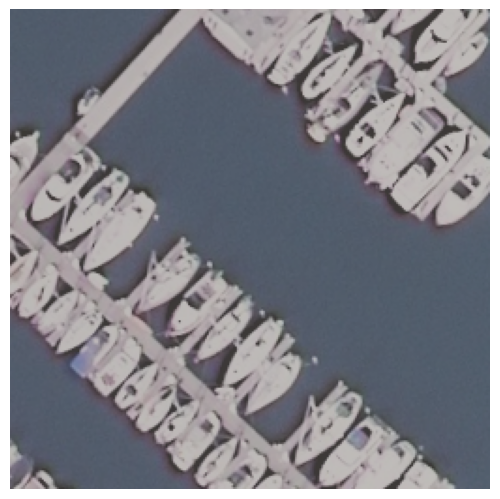

In [36]:
plt.imshow(sample_images[10, 0].clip(0, 1).numpy().transpose(1, 2, 0))
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

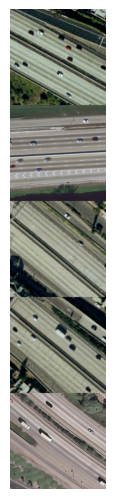

In [37]:
images = einops.rearrange((sample_images[8, :]).clip(0, 1), 'e c h w -> (e h) w c')
# plt.imsave("output/ucmerced_denseresidentials.png", images.numpy())
plt.imshow(images)
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)

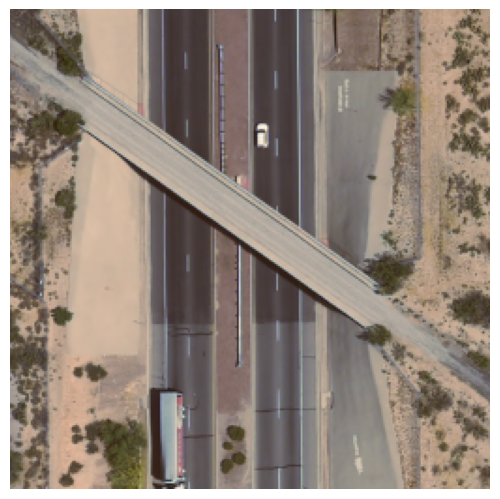

In [60]:
plt.imshow(sample_images[11, 2].clip(0, 1).numpy().transpose(1, 2, 0))
plt.axis("off")
plt.autoscale(False)
plt.tight_layout(pad=0)